# 1) Data Loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
spark = SparkSession.builder \
    .appName("myapp") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .master('local[*]') \
    .getOrCreate()

24/12/05 10:23:47 WARN Utils: Your hostname, MacBook-Air-mba.local resolves to a loopback address: 127.0.0.1; using 192.168.1.143 instead (on interface en0)
24/12/05 10:23:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 10:23:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# df = spark.read.csv('dataset/preprocessed_data/preprocessedData_SI.csv', header=True, inferSchema=True)
df = spark.read.csv('/Users/savato/Data Science/ddam/dataset/PreprocessedDataStringIndexed.csv/dataset_preprocessed.csv', header=True, inferSchema=True)

In [4]:
#Rename target_bool column to label
df_transformed = df.withColumnRenamed("fraud_bool", "label")

# 2) Train Test Split

In [5]:
df_transformed.show(5)

+-----+-------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|             income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_mo

24/12/05 10:23:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
# split train test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)
train_data.groupBy('label').count().show()
test_data.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|791463|
|  1.0|  8827|
+-----+------+



24/12/05 10:24:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----+------+
|label| count|
+-----+------+
|  0.0|197508|
|  1.0|  2202|
+-----+------+



In [7]:
train_data.show(5)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid| bank_months_count|has_other_cards|pro

# 3) Sampling

## No technique

In [8]:
train_data_sampled = train_data
test_data_sampled = test_data

## Random Undersampling

In [8]:
# Under-sampling the majority class
majority_class = train_data.filter(train_data['label'] == 0)
minority_class = train_data.filter(train_data['label'] == 1)

# Setting the seed for reproducibility
seed = 42
# Downsample the majority class
majority_downsampled = majority_class.sample(False, minority_class.count() / majority_class.count(), seed)

# Combine the downsampled majority class with the minority class
train_data_sampled = majority_downsampled.union(minority_class)

# Show the number of fraud and non-fraud transactions
train_data_sampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8888|
|  1.0| 8827|
+-----+-----+



## Random Oversampling

In [8]:
# Separate the majority and minority classes
majority_class = train_data.filter(train_data['label'] == 0)
minority_class = train_data.filter(train_data['label'] == 1)

# Calculate the ratio to oversample the minority class
ratio = majority_class.count() / minority_class.count()

print(f"Ratio: {ratio}")    

# Oversample the minority class
minority_oversampled = minority_class.sample(withReplacement=True, fraction=ratio, seed=42)

# Combine the oversampled minority class with the majority class
train_data_sampled = majority_class.union(minority_oversampled)

# Show the number of fraud and non-fraud transactions
train_data_sampled.groupBy('label').count().show()

Ratio: 89.66387221026396


+-----+------+
|label| count|
+-----+------+
|  0.0|791463|
|  1.0|791109|
+-----+------+



## Weights "sampling"

In [12]:
total_count = train_data.count()
pos_count = train_data.filter(col("label") == 1).count()
neg_count = total_count - pos_count

# Compute class weights
pos_weight = total_count / (2.0 * pos_count)
neg_weight = total_count / (2.0 * neg_count)

print(f"Positive weight: {pos_weight}")
print(f"Negative weight: {neg_weight}")

# Add the weight column to the dataset
train_data_sampled = train_data.withColumn(
    "weight", when(col("label") == 1, pos_weight).otherwise(neg_weight)
)


Positive weight: 45.33193610513198
Negative weight: 0.5055763819660553


# 4) Prepare data (trasform to features+label)

In [9]:
train_data_sampled.show(5)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_months_count|has_other_cards|p

In [10]:
test_data.show(2)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_months_count|has_other_cards|pro

In [11]:
from pyspark.ml.feature import VectorAssembler

# Define all feature columns (exclude "label")
feature_columns = [col for col in train_data_sampled.columns if col not in ["label", "weight"]]
print(feature_columns)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply the transformation to both train and test data
train_data_prepared = vector_assembler.transform(train_data_sampled).select("features", "label")

# Define all feature columns (exclude "label")
feature_columns = [col for col in test_data.columns if col != "label"]
print(feature_columns)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
test_data_prepared = vector_assembler.transform(test_data).select("features", "label")

# show the distribution of label in train_data_prepared
train_data_prepared.groupBy('label').count().show()

['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'month_encoded', 'payment_type_encoded', 'employment_status_encoded', 'housing_status_encoded', 'source_encoded', 'device_os_encoded']
['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8888|
|  1.0| 8827|
+-----+-----+



In [12]:
train_data_prepared.select('features').show(5, truncate=False)
train_data_prepared.show(2)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,0.0332905828...|  0.0|
|[0.0,0.0370726570...|  0.0|
+--------------------+-----+
only showing top 2 rows



In [13]:
test_data_prepared.select('features').show(5, truncate=False)
test_data_prepared.show(2)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,1.3371449303...|  0.0|
|[0.0,4.2384881753...|  0.0|
+--------------------+-----+
only showing top 2 rows



# Dummy model

(always predict majority class)

In [43]:
from pyspark.sql import functions as F

# calculate majority class
majority_class = train_data_prepared.groupBy('label').count().orderBy('count', ascending=False).first()[0]
print(f"Majority class: {majority_class}")

# add column prediction with majority class
predictions = test_data_prepared.withColumn("prediction", F.lit(majority_class))

# add column rawPrediction with Double value 1.0
predictions = predictions.withColumn("rawPrediction", F.lit(1.0))

predictions.show(5)

Majority class: 0.0


+--------------------+-----+----------+-------------+
|            features|label|prediction|rawPrediction|
+--------------------+-----+----------+-------------+
|[0.0,1.3371449303...|  0.0|       0.0|          1.0|
|[0.0,4.2384881753...|  0.0|       0.0|          1.0|
|[0.0,9.5322385080...|  0.0|       0.0|          1.0|
|[0.0,0.0018702182...|  0.0|       0.0|          1.0|
|[0.0,0.0024724864...|  0.0|       0.0|          1.0|
+--------------------+-----+----------+-------------+
only showing top 5 rows



# RandomForest

## Grid Search

In [ ]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# from pyspark.ml.classification import RandomForestClassifier
# rf = RandomForestClassifier(featuresCol="features", labelCol="label")


# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [150, 200, 250]) \
#     .addGrid(rf.maxDepth, [10, 15]) \
#     .addGrid(rf.minInstancesPerNode, [2, 5]) \
#     .build()

# cv = CrossValidator(estimator=rf, 
#                     estimatorParamMaps=paramGrid, 
#                     evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"), 
#                     numFolds=2)

# cvModel = cv.fit(train_data_sampled)

In [ ]:
# # Recupera il modello migliore
# best_model = cvModel.bestModel

# # Ottieni i parametri migliori
# num_trees = best_model.getNumTrees
# max_depth = best_model.getMaxDepth()
# min_instances_per_node = best_model.getMinInstancesPerNode()

# # Stampa i valori
# print("Best Parameters:")
# print(f" - numTrees: {num_trees}")
# print(f" - maxDepth: {max_depth}")
# print(f" - minInstancesPerNode: {min_instances_per_node}")

Best Parameters:
 - numTrees: 150
 - maxDepth: 10
 - minInstancesPerNode: 1


## Best params (my pc cannot go further)

In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Define the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=150, maxDepth=10, \
    # weightCol="weight"\
        )

# Step 2: Train the Model on Train Data
rf_model = rf.fit(train_data_prepared)

# Step 3: Make Predictions on Test Data
predictions = rf_model.transform(test_data_prepared)

24/12/05 10:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1502.5 KiB
24/12/05 10:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/12/05 10:26:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/12/05 10:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1275.8 KiB
24/12/05 10:26:10 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
24/12/05 10:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1962.8 KiB
24/12/05 10:26:16 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
24/12/05 10:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


# Confusion Matrix, Precision, Recall, F1, AUC

In [25]:
print(type(predictions))
predictions.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>


24/12/04 19:06:34 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.3371449303...|  0.0|[116.436423055140...|[0.77624282036760...|       0.0|
|[0.0,4.2384881753...|  0.0|[132.185834728776...|[0.88123889819184...|       0.0|
|[0.0,9.5322385080...|  0.0|[105.876656665612...|[0.70584437777074...|       0.0|
|[0.0,0.0018702182...|  0.0|[125.280535969204...|[0.83520357312802...|       0.0|
|[0.0,0.0024724864...|  0.0|[104.052133577898...|[0.69368089051932...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



24/12/04 19:06:42 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
24/12/04 19:07:01 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
24/12/04 19:07:03 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB



Metrics:
Class 0 (False): Precision = 1.00, Recall = 0.86, F1-Score = 0.92
Class 1 (True):  Precision = 0.05, Recall = 0.70, F1-Score = 0.10
AUC: 0.8737


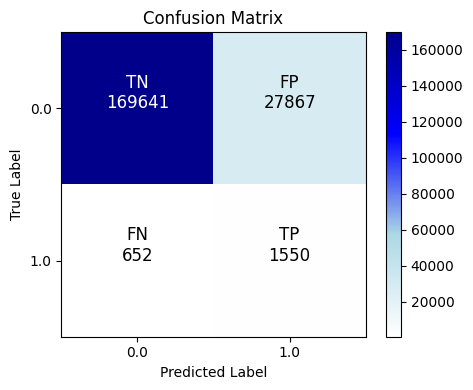

In [26]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Create a full confusion matrix
labels = [0.0, 1.0]
predictions_full = (
    predictions.groupBy("label", "prediction")
    .count()
    .withColumnRenamed("count", "actual_count")
)

# Add missing combinations with a count of 0
from pyspark.sql import Row
all_combinations = [
    Row(label=float(lbl), prediction=float(pred)) for lbl in labels for pred in labels
]
all_combinations_df = spark.createDataFrame(all_combinations)
confusion_matrix_full = (
    all_combinations_df.join(
        predictions_full, ["label", "prediction"], "left_outer"
    )
    .fillna(0, subset=["actual_count"])
)

# Convert to Pandas for visualization
confusion_matrix_pd = confusion_matrix_full.toPandas()

# Create confusion matrix array
confusion_matrix_array = np.zeros((len(labels), len(labels)))
for _, row in confusion_matrix_pd.iterrows():
    i = labels.index(row["label"])
    j = labels.index(row["prediction"])
    confusion_matrix_array[i, j] = row["actual_count"]

# Step 2: Extract TP, FP, FN, TN
tp = confusion_matrix_array[1, 1]  # True Positives
fp = confusion_matrix_array[0, 1]  # False Positives
fn = confusion_matrix_array[1, 0]  # False Negatives
tn = confusion_matrix_array[0, 0]  # True Negatives

# Step 3: Calculate Metrics
precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

# Calculate AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)

# Step 4: Display Metrics
print("\nMetrics:")
print(f"Class 0 (False): Precision = {precision_0:.2f}, Recall = {recall_0:.2f}, F1-Score = {f1_0:.2f}")
print(f"Class 1 (True):  Precision = {precision_1:.2f}, Recall = {recall_1:.2f}, F1-Score = {f1_1:.2f}")
print(f"AUC: {auc:.4f}")

# Step 5: Plot Confusion Matrix with Annotations
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["white", "lightblue", "blue", "darkblue"]
)

plt.figure(figsize=(5, 4))
plt.imshow(confusion_matrix_array, interpolation="nearest", cmap=custom_cmap)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Add counts and acronyms in each cell
annotations = [["TN", "FP"], ["FN", "TP"]]
thresh = confusion_matrix_array.max() / 2.0
for i in range(len(labels)):
    for j in range(len(labels)):
        count = int(confusion_matrix_array[i, j])
        label = annotations[i][j]
        plt.text(
            j,
            i,
            f"{label}\n{count}",
            horizontalalignment="center",
            color="white" if confusion_matrix_array[i, j] > thresh else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()
